The goal of the this notebook is to serve as a resource for PTMPsi users to generate data and go through the post processing analysis. 

0) Set up:

0.01) You will need access to https://pnnl-ldrds.elements.quantum.azure.com/pun/sys/dashboard, the microsoft cloud supercomputers. Daniel Rodriguex and Paul Rigor can help grant access. 

0.02) If you get Bad Request error (after you already have access): 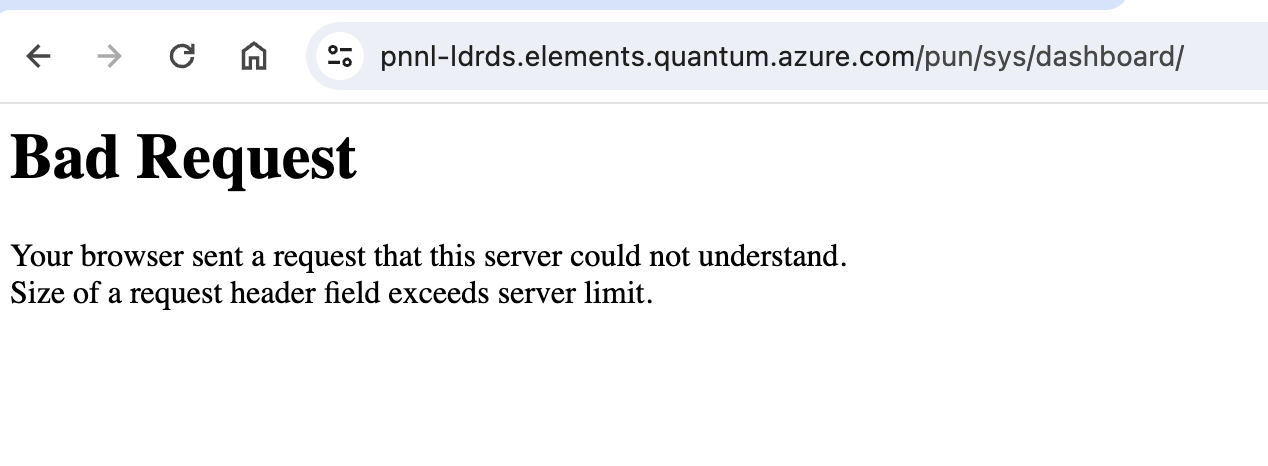 Try using Safari. Originally I could connect on Chrome, but now it never connects. If you get this error on Safari  restart your browser. If this persists, restart you computer. 

0.03) Basic bash commands are useful. You can use AI incubator or google to get the syntax of the command. The main things I use is "cd"--change directory, and "ls" -- list files. Sometimes I need to copy or remove files as well. Also, there are functions you can use in vim to modify a file. If you have never have used vim it is a little weird. Use AI incubator to get an overview on how to use bash or vim if needed. 

0.1) Connect your computer key to the cluster shell so you can connect your terminal to the cloud: Once you have access, from the dashboard click on the AZHOP- Cluster Shell Access: 
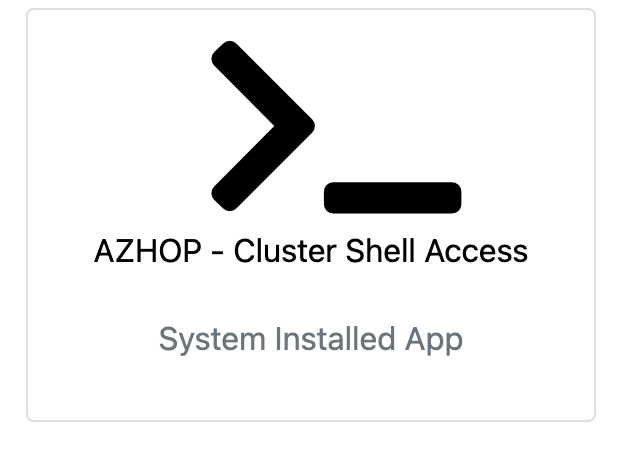
You should be on a page like this: 
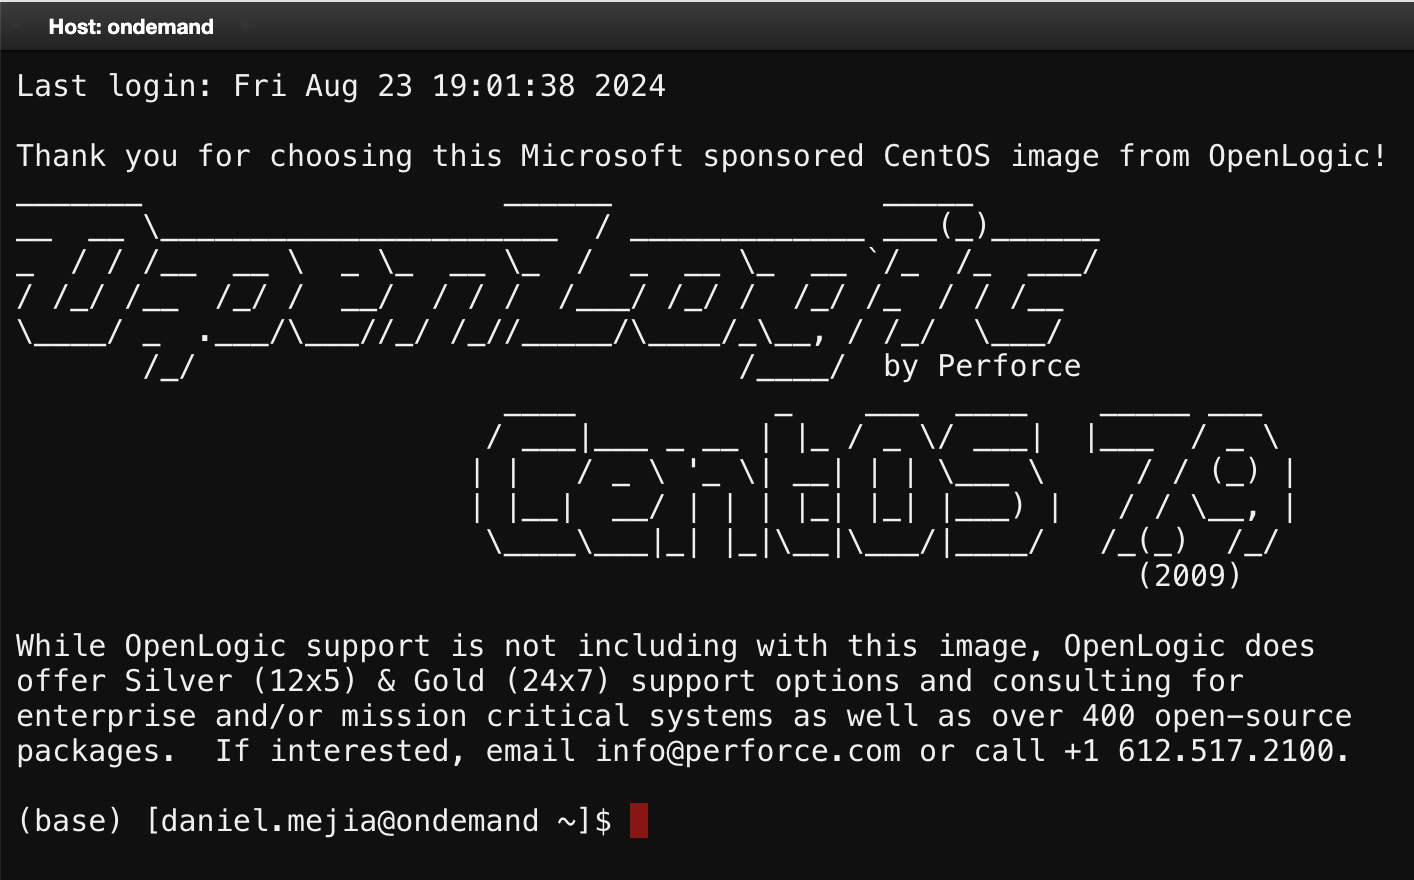

Open ~/.ssh/authorized_keys using the editor of your choice like vim, nano, emac, or vi. For example type
"vi ~/.ssh/authorized_keys" (without quotes). This will open the file. Paste your .pub key into this file. You may need to google how to find your key (and possibly generate) for your operating system. You should be able to access the cloud on your computer now without web brower.

Open a terminal on your computer. Connect by typing: "ssh {username}@pnnl-ldrds.elements.quantum.azure.com". Mine looks like this: 
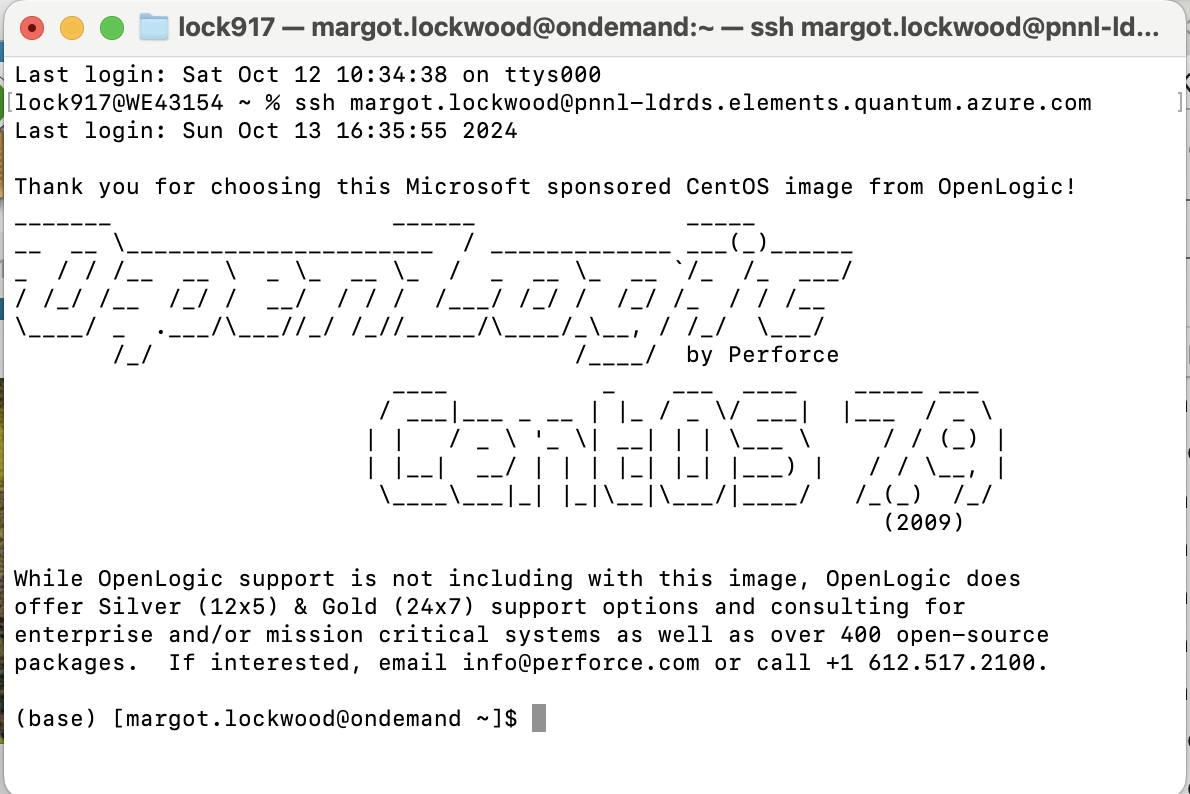

You can now access the supercomputer on using this terminal. Alternatively, you can use the web browser. Note, you need to be connected to the VPN to access any of this. 


0.2) Access Jupyter Notebook. 
From the dashboard you can launch a jupyter notebook session by clicking:
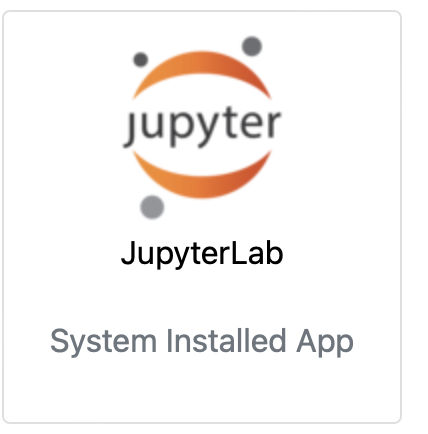. 
You can start you session. Choose the amount of hours you want your session to connect and the computing partition. 
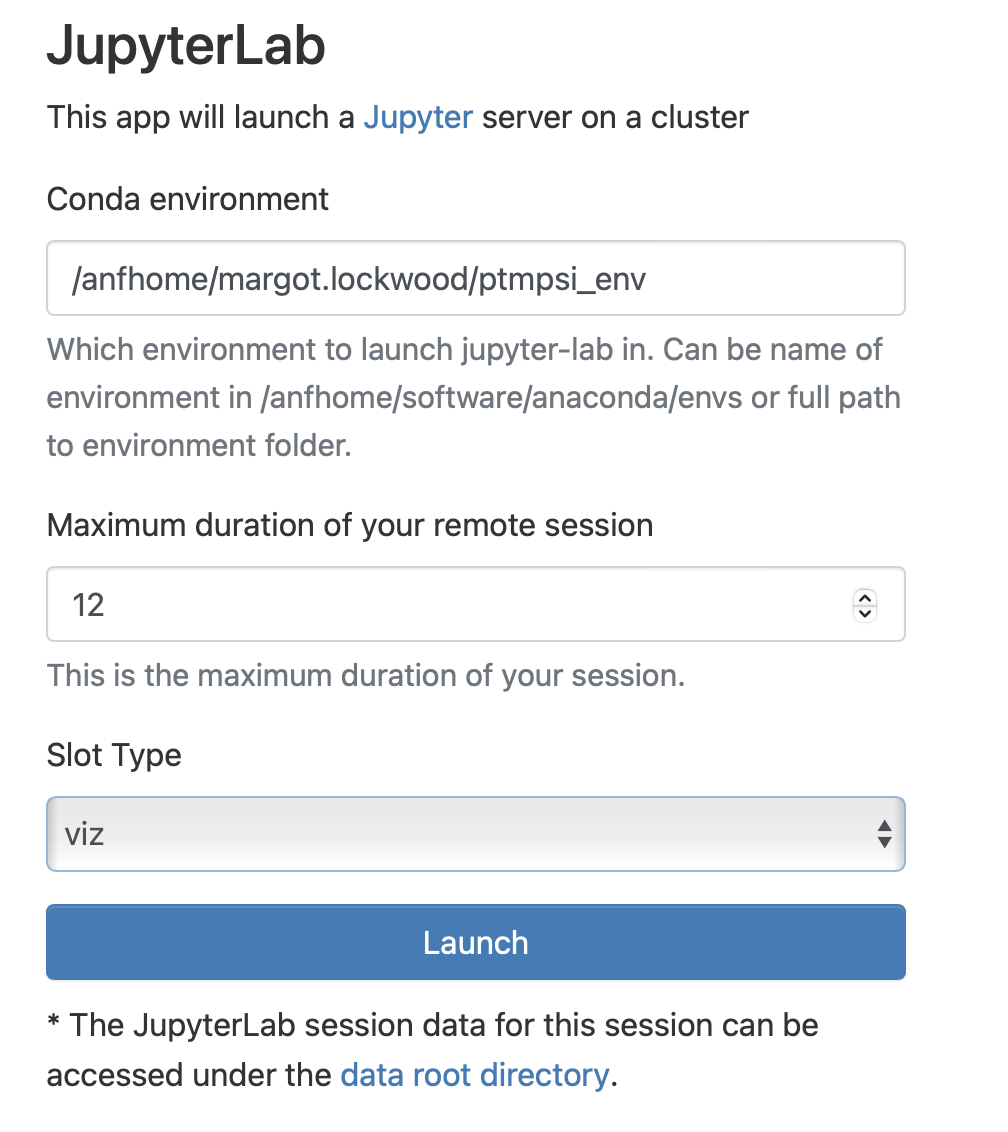
Different partitions have different amounts of CPUs and nodes. The price varies for these. NOTE you should close your session when you done, espicially if using a more expensive parition. If you do not need a lot of computing power use "viz". This is not very expensive and is OK if you leave open. If you are doing post processing analysis, a more powerful partition is need. You can use "bsc120c". When we submit jobs the cluster using .sbatch files, these files are configured so we usually use "prm40c8g" or "prm96c4g". 

You can run the following commands in this notebook. 

0.3) Access Linux Desktop. Click "Linux Desktop" icon: 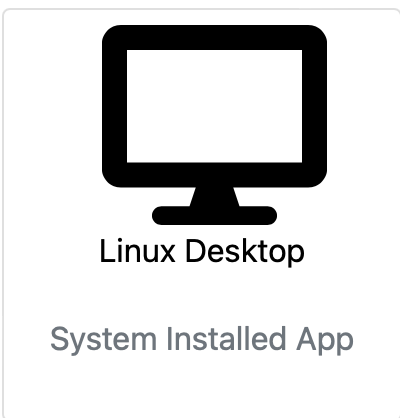. Use With GPU, set duration, and launch. You can access the files using Linux Desktop if you prefer. In my experience using this is slow and I only use this for VMD, visualizations of protiens. 

0.4) Pull PTMPSI: 
In terminal: 
cd $HOME/ptmpsi_env/PTMPSI
git pull origin aqe



1) Generate files: 

In [ ]:
import os

os.chdir("/anfhome/shared/qipd/newmds/{insert file location}") #move to the directory you want to generate the new files
#{insert file loaciton} is usually the type of PTM like NAD_in_A or NAD_in_AD
#os.getcwd() #confirm you are in the correct spot

In [ ]:
import ptmpsi
# Save current working directory
cwd = os.getcwd()

# Modify path to find pbd2pqr
os.environ["PATH"] += os.pathsep + os.environ["HOME"] + "/ptmpsi_env/bin"

# Load protein (GAP2)
protein = ptmpsi.protein.Protein(pdbid="6GVE")

In [ ]:
combinations = [[
    (("A:CYS77", "reduction"),), # Dummy (NATIVE)
]]

# PTM in C77 of GAPDH
for ptm in ["nitrosylation", "sulfhydration", "glutathionylation"]:
    t1 = ()
    for chain in "ADEFIKNO":
        t1 += ((f"{chain}:CYS77", ptm),)
    combinations[0].append(t1)

# PTM C13,C35 of all PRK
for ptm in ["nitrosylation", "sulfhydration", "glutathionylation"]:
    t1 = ()
    for chain in "BLGJ":
        t1 += ((f"{chain}:CYX13", ptm),)
        t1 += ((f"{chain}:CYX35", ptm),)
    combinations[0].append(t1)

#PTM C224, C230 of all PRK
for ptm in ["nitrosylation", "sulfhydration", "glutathionylation"]:
    t1 = ()
    for chain in "BLGJ":
        t1 += ((f"{chain}:CYX224", ptm),)
        t1 += ((f"{chain}:CYX230", ptm),)
    combinations[0].append(t1)

#PTM C61, C70 of all CP12
for ptm in ["nitrosylation", "sulfhydration", "glutathionylation", "reduction"]:
    t1 = ()
    for chain in "PCHM":
        t1 += ((f"{chain}:CYX61", ptm),)
        t1 += ((f"{chain}:CYX70", ptm),)
    combinations[0].append(t1)

#Reduce C19, C29 of all CP12
t1 = ()
for chain in "PCHM":
    t1 += ((f"{chain}:CYX61", "reduction"),)
    t1 += ((f"{chain}:CYX70", "reduction"),)
combinations[0].append(t1)

#Reduce all disulfides of CP12
t1 = ()
for chain in "PCHM":
    t1 += ((f"{chain}:CYX19", "reduction"),)
    t1 += ((f"{chain}:CYX29", "reduction"),)
    t1 += ((f"{chain}:CYX61", "reduction"),)
    t1 += ((f"{chain}:CYX70", "reduction"),)
combinations[0].append(t1)

In [ ]:
machine = ptmpsi.slurm.aqe_ldrd
uid1 = protein.gen_ptm_files(combinations, machine=machine, partition="prm40c8g", thermo=False, nsplit=1, cofactor="NAD.pdb", **machine.partitions["prm40c8g"].options["gromacs"])

The above generates the folders and files. Depending on what combinations you want to look at, the code can differ. Ask Daniel Rodriguez about this. 

2) Generate data by submitting jobs to cluster. Navigate to the directory (you set in the begining) where you generated the files above. In this directory there is a file namesd a long random string, like "1280ec92-875e-450d-966b-4550ebedc82e". You can navigate to these on your Jupyter Notebook of in your terminal. This is just a unique name for the run. Inside this file there are more files like: 1tuples, amber99sb,ff, README... ect like:
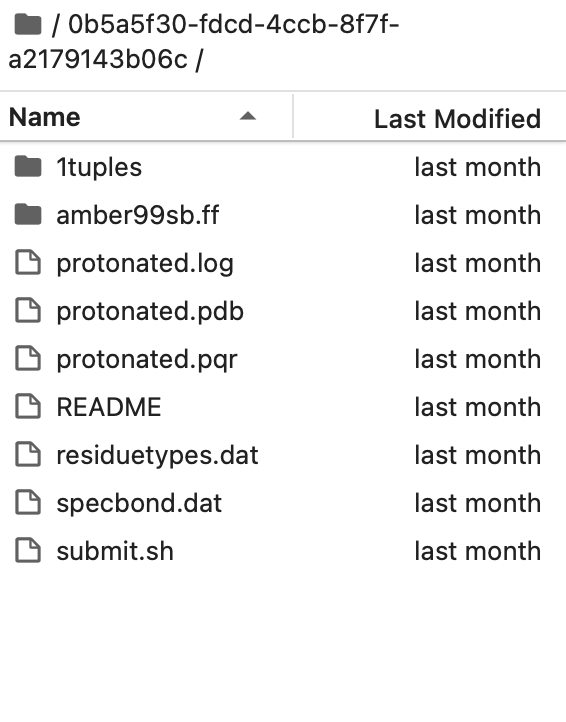

If there was an error, you can check other the .log files. Inside the 1tuples file there are more directories labeled "000", "0001", "0002"... ect. These files differ with different modications (for example nitrosylation or sulfhydration for different parts of the protien). More information about these changes are in the README file. The amber99sb.ff files has informations about forcefields, dna, and amino acids, ect...

In your terminal or with the equivilent os python command in your notebook, once you are in the same directory as the file you can submit jobs to the cluster. 

"sh submit.sh" can be used to submit the whole run for all the 1tuples files. If you need to submit just one run (for example the cluster shut down mid run or there was an error) you can resubmit individual runs by navigating into the desired file in 1tuples. Then you can submit the run by typing "sbatch 00XX_slurm.sbatch" where XX corresponds to the number of the desired file. You need to be in the correct file to do this. 

Check on your jobs by typing "squeue -u {username}". Mine looks like this:
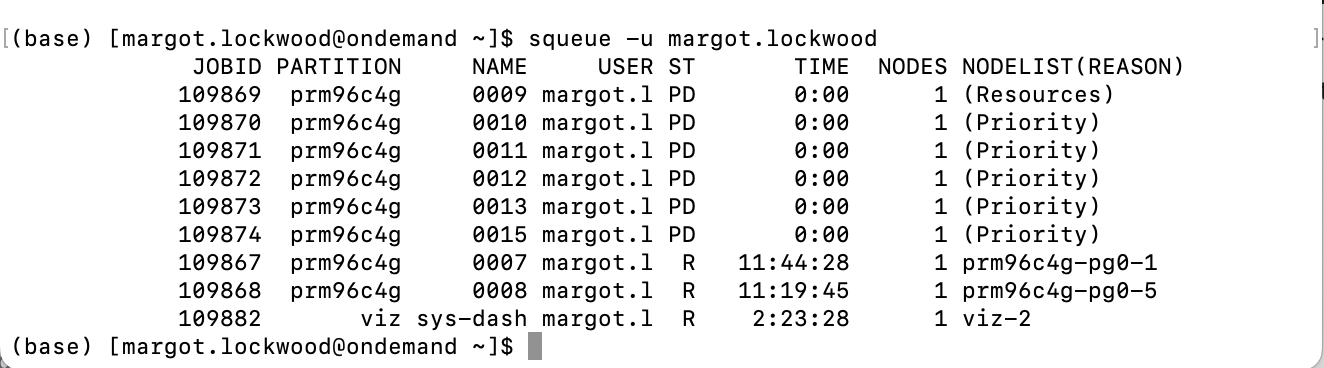

These jobs can take a while to configure and even 20+ hours run. More jobs will run if depending how many nodes are available. 

3) Post Proccessing Function
The analysis/py script is located: "ptmpsi_env/PTMPSI/ptmpsi/gromacs/analysis.py". You may need to modify this script. You can look at it here: https://github.com/pnnl/PTMPSI/blob/aqe/ptmpsi/gromacs/analysis.py

The post_processs function need 3 input files, the trajetory, structure, and index files. The output is 5 files. The function removes translations, kinetics, and rotations from the structure. 

Run this on "bsc120c" parition when launching your jupyter notebook. 
Modify and run the following code to do post processing:

In [1]:
import os
import ptmpsi
import ptmpsi.gromacs.analysis

os.chdir("/anfhome/margot.lockwood/ptmpsi_env") #CHANGE TO YOUR USERNAME

#Give the file paths you want to run post proccessing for. This can handle an array of files. 
file=["/anfhome/shared/qipd/newmds/NAD_in_AD/eda6b09c-b9f2-42c9-be15-0204ed29807a"]

for filename in file:
    for n in range(0, 1): # range (0,16) workds for 1tuples 0000-0015. Modify for more or less
        if n<10:
            print("here")
            trajectory = f"{filename}/1tuples/000{n}/md.xtc"
            structure  = f"{filename}/1tuples/000{n}/md.tpr"
            index      = f"{filename}/1tuples/000{n}/index.ndx"
            #change prefix in the following line  to be the location of where you want to save the post_proccessing data
            ptmpsi.gromacs.analysis.post_process(trajectory, structure, index, prefix=f"/anfhome/shared/qipd/newmds/postprocess/NAD_in_DE/6800f629-7cb9-4526-9f85-0c19eab37653/000{n}", interactive=True)
        else:
            trajectory = f"{filename}/1tuples/00{n}/md.xtc"
            structure  = f"{filename}//1tuples/00{n}/md.tpr"
            index      = f"{filename}/1tuples/00{n}/index.ndx"
            #change prefix in the following line  to be the location of where you want to save the post_proccessing data
            ptmpsi.gromacs.analysis.post_process(trajectory, structure, index, prefix=f"/anfhome/shared/qipd/newmds/postprocess/NAD_in_DE/6800f629-7cb9-4526-9f85-0c19eab37653/00{n}", interactive=True)
print("done")

here
Found 120 physical CPUs available
Will use 90 CPUs at the same time


Loading gcc/13.2.0/gcc8.5.0-ond4w
  Loading requirement: gmp/6.2.1/gcc8.5.0-4sfwk mpfr/4.2.0/gcc8.5.0-vpqlx
    mpc/1.3.1/gcc8.5.0-hjjc4 zlib/1.2.13/gcc8.5.0-tsfrd
    zstd/1.5.5/gcc8.5.0-ne734

Loading intel-oneapi-mkl/2023.2.0/gcc13.2.0-hpcx_mpi-ddupx
  Loading requirement: hpcx-mpi/2.15/gcc13.2.0-4fm52
    intel-oneapi-tbb/2021.10.0/gcc13.2.0-46fb2
                     :-) GROMACS - gmx trjconv, 2024.3 (-:

Executable:   /anfhome/shared/qipd/gromacs/bin/gmx
Data prefix:  /anfhome/shared/qipd/gromacs
Working dir:  /anfhome/margot.lockwood/ptmpsi_env
Command line:
  gmx trjconv -f /anfhome/shared/qipd/newmds/postprocess/NAD_in_DE/6800f629-7cb9-4526-9f85-0c19eab37653/0000/md_whole_nojump.xtc -o /anfhome/shared/qipd/newmds/postprocess/NAD_in_DE/6800f629-7cb9-4526-9f85-0c19eab37653/0000/md_whole_nojump_fit.xtc -fit rot+trans -s /anfhome/shared/qipd/newmds/postprocess/NAD_in_DE/6800f629-7cb9-4526-9f85-0c19eab37653/0000/md.gro

Will write xtc: Compressed trajectory (portable xdr format): x

Note that major changes are planned in future for trjconv, to improve usability and utility.

         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary. Note, that this functionality may
         be removed in a future GROMACS version. Please, consider
         using another file format for your input.

Select group for least squares fit
Selected 3: 'C-alpha'
Select group for output
Selected 0: 'System'
Selected 14: 'non-Water'
done


Group     0 (         System) has 776602 elements
Group     1 (        Protein) has 65996 elements
Group     2 (      Protein-H) has 33252 elements
Group     3 (        C-alpha) has  4272 elements
Group     4 (       Backbone) has 12816 elements
Group     5 (      MainChain) has 17104 elements
Group     6 (   MainChain+Cb) has 21064 elements
Group     7 (    MainChain+H) has 21244 elements
Group     8 (      SideChain) has 44752 elements
Group     9 (    SideChain-H) has 16148 elements
Group    10 (    Prot-Masses) has 65996 elements
Group    11 (    non-Protein) has 710606 elements
Group    12 (          Water) has 709050 elements
Group    13 (            SOL) has 709050 elements
Group    14 (      non-Water) has 67552 elements
Group    15 (            Ion) has  1556 elements
Group    16 ( Water_and_ions) has 710606 elements
Select a group: Will write subset non-Water of original tpx containing 67552 atoms
Reduced ilist    BONDS from  33928 to  33928 entries
Reduced ilist   ANGLES fro

This code should generate 5 new files in the location specified by "prefix". 
Mine look like: 
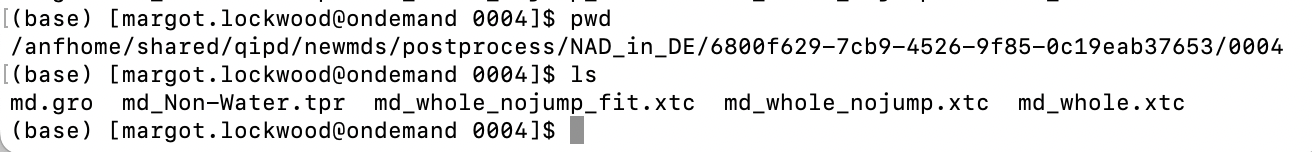

4) DSSP Function
dssp function is also located in analysis.py file.  DSSP in gromacs is a tool for defining secondary structures of proteins and trajectories. dssp function in analysis.py takes inputs trajectory and structure. This time we use files generated from post_procces function. Both this step and the previous step could be run on using a slurm batch script. This could be good in the future as both these take a lot of time to run. The following function takes about 30 minutes per each case. 

In [ ]:
import os
import ptmpsi
import ptmpsi.gromacs.analysis

os.chdir("/anfhome/margot.lockwood/ptmpsi_env")

file=["/anfhome/shared/qipd/newmds/postprocess/NAD_in_A/563e2df5-82de-4918-967d-70e733cfa584"] #note this file path is the location of the post_process prefix 


for filename in file:
    for n in range(0, 1):
        if n<10:
            trajectory = f"{filename}/000{n}/md_whole_nojump_fit.xtc"
            structure  = f"{filename}/000{n}/md_Non-Water.tpr"

            ptmpsi.gromacs.analysis.dssp(trajectory, structure, output_dir=f"{filename}/000{n}/dat", interactive=True)
        else: 
            trajectory = f"{filename}/00{n}/md_whole_nojump_fit.xtc"
            structure  = f"{filename}/00{n}/md_Non-Water.tpr"
        
        
            ptmpsi.gromacs.analysis.dssp(trajectory, structure, output_dir=f"{filename}/00{n}/dat", interactive=True)
print("done")
print(os.getcwd())

In [ ]:
5) 